# Analyzing Cisplatin-Binding Transcripts via GLM-SAE Knowledge Graphs

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from networkx.readwrite import json_graph

import os, json

with open("data/cisplatin_pos_kg.json") as f:
    data = json.load(f)

G: nx.MultiDiGraph = json_graph.node_link_graph(data, edges="edges")
print(G)

MultiDiGraph with 6172 nodes and 848782 edges


In [2]:
# graph is large, so lets trim down a version we can visualize
OG = G.copy()

# filter features that only respond to one token
to_remove = [n for n in G.nodes if G.in_degree(n) == 1]
G.remove_nodes_from(to_remove)
print(G)

# the '<cls>' token is the 'start' token and does not encode genetic info
if G.has_node('<cls>'):
    G.remove_node('<cls>')
    print(G)

# find average edge bundle size
edge_sizes = {(u,v): len(G.get_edge_data(u, v)) for u, v, k in G.edges}
avg_edge_size = sum(edge_sizes.values()) / len(edge_sizes)
print(f"Average edge bundle size: {avg_edge_size}")
print(f"Median edge bundle size: {np.median(list(edge_sizes.values()))}")
print(f"Number of edge bundles: {len(edge_sizes)}")
print(f"Max edge bundle size: {max(edge_sizes.values())}")
print(f"Min edge bundle size: {min(edge_sizes.values())}")
print(f"Standard deviation of edge bundle sizes: {pd.Series(edge_sizes.values()).std()}")

# filter edges that have less than 5 samples in their bundle, then show new descriptive stats
print("---------- Filtering edges with less than 5 samples in their bundle ----------")
to_remove = [key for key, size in edge_sizes.items() if size < 5]
for ebundle in to_remove:
    u, v = ebundle
    keys = list(G.get_edge_data(u, v).keys())
    for k in keys:
        G.remove_edge(u, v, k)
# G.remove_edges_from(to_remove)
print(G)

edge_sizes = {(u,v): len(G.get_edge_data(u, v)) for u, v, k in G.edges}
avg_edge_size = sum(edge_sizes.values()) / len(edge_sizes)
print(f"Average edge bundle size: {avg_edge_size}")
print(f"Median edge bundle size: {np.median(list(edge_sizes.values()))}")
print(f"Number of edge bundles: {len(edge_sizes)}")
print(f"Max edge bundle size: {max(edge_sizes.values())}")
print(f"Min edge bundle size: {min(edge_sizes.values())}")
print(f"Standard deviation of edge bundle sizes: {pd.Series(edge_sizes.values()).std()}")

# re-filter features that only respond to one token or are disconnected from the graph
to_remove = [n for n in G.nodes if G.in_degree(n) <= 1 and type(n) == int]
G.remove_nodes_from(to_remove)
print(G)

MultiDiGraph with 5879 nodes and 848489 edges
MultiDiGraph with 5878 nodes and 804654 edges
Average edge bundle size: 5.4587231271242205
Median edge bundle size: 1.0
Number of edge bundles: 147407
Max edge bundle size: 8785
Min edge bundle size: 1
Standard deviation of edge bundle sizes: 51.929513896535106
---------- Filtering edges with less than 5 samples in their bundle ----------
MultiDiGraph with 5878 nodes and 628643 edges
Average edge bundle size: 23.83480568720379
Median edge bundle size: 10.0
Number of edge bundles: 26375
Max edge bundle size: 8785
Min edge bundle size: 5
Standard deviation of edge bundle sizes: 121.06815764725847
MultiDiGraph with 4847 nodes and 628643 edges


In [3]:
# use annotations to create two graphs of coding and non-coding genomic regions
coding_regions = [e for e in G.edges(data=True, keys=True) if len(e[3]["annotations"]) != 0]
non_coding_regions = [e for e in G.edges(data=True, keys=True) if len(e[3]["annotations"]) == 0]

G_coding = nx.MultiDiGraph()
for edge in coding_regions:
    G_coding.add_edge(edge[0], edge[1], edge[2], **edge[3])
G_non_coding = nx.MultiDiGraph()
for edge in non_coding_regions:
    G_non_coding.add_edge(edge[0], edge[1], edge[2], **edge[3])

print(f"Coding graph: {G_coding}")
print(f"Non-coding graph: {G_non_coding}")

Coding graph: MultiDiGraph with 4259 nodes and 57857 edges
Non-coding graph: MultiDiGraph with 4819 nodes and 570786 edges


Top 10 nodes by PageRank:
Node: 3378, PageRank: 0.0954266669857938
Node: 4793, PageRank: 0.08614907113905293
Node: 407, PageRank: 0.061096425645242314
Node: 2558, PageRank: 0.03625600953741979
Node: 1545, PageRank: 0.023343081013678275
Node: 7612, PageRank: 0.012794219706204188
Node: 4014, PageRank: 0.012123968309706341
Node: 6445, PageRank: 0.011541107115998062
Node: 8707, PageRank: 0.009984743551191775
Node: 5234, PageRank: 0.006128120327257333


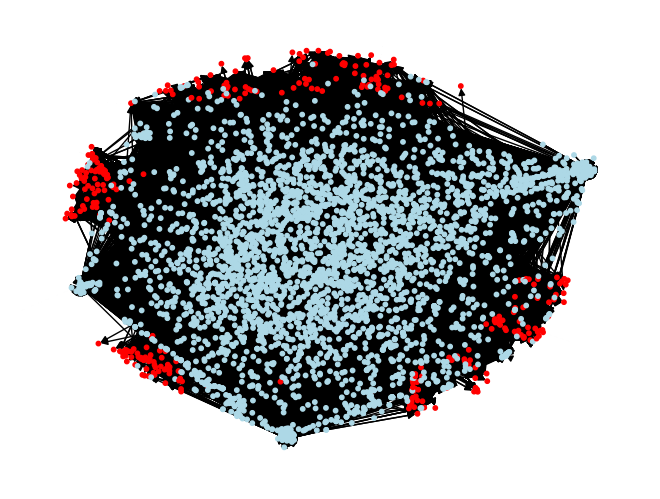

In [4]:
def node_color(x):
    return "lightblue" if type(x) == str else "red"

pagerank = nx.pagerank(G_coding)
sorted_pr = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
print("Top 10 nodes by PageRank:")
for node, pr in sorted_pr[:10]:
    print(f"Node: {node}, PageRank: {pr}")


nx.draw(G_coding, pos=nx.forceatlas2_layout(G_coding), with_labels=False, node_size=10, font_size=4, node_color=[node_color(n) for n in G_coding.nodes()])

Top 10 nodes by PageRank:
Node: 4793, PageRank: 0.08619088307944313
Node: 3378, PageRank: 0.08197376340176783
Node: 407, PageRank: 0.06606307825285299
Node: 2558, PageRank: 0.03135147332159834
Node: 1545, PageRank: 0.02090430544453861
Node: 6445, PageRank: 0.011221303671365012
Node: 4014, PageRank: 0.010348503106505865
Node: 7612, PageRank: 0.010329536147393735
Node: 8707, PageRank: 0.009763513600654507
Node: 5234, PageRank: 0.0055785592500795


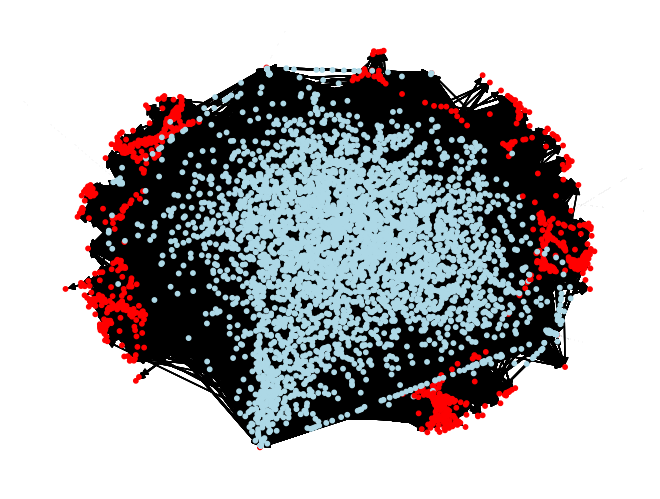

In [5]:
pagerank = nx.pagerank(G_non_coding)
sorted_pr = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
print("Top 10 nodes by PageRank:")
for node, pr in sorted_pr[:10]:
    print(f"Node: {node}, PageRank: {pr}")

nx.draw(G_non_coding, pos=nx.forceatlas2_layout(G_non_coding), with_labels=False, node_size=10, font_size=4, node_color=[node_color(n) for n in G_non_coding.nodes()])

In [6]:
# COMPARE TO ORIGINAL GRAPH
# use page rank to measure centrality
pagerank = nx.pagerank(OG)
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

print("Nodes ranked by PageRank:")
for node, score in sorted_pagerank[:10]:  # top 10 nodes
    print(f"{node}: {score}")

Nodes ranked by PageRank:
3378: 0.05591438534474252
4793: 0.04776315882634009
407: 0.04058334611930585
2558: 0.02174499892379862
1545: 0.014473227554864115
7612: 0.009225784115039545
6445: 0.00832866187503917
8707: 0.008153740563806095
4014: 0.00770609877987153
9685: 0.005610925728333565


In [7]:
# COMPARE TO ORIGINAL GRAPH
# compare with degree centrality
degree_centrality = nx.degree_centrality(OG)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

print("Nodes ranked by Degree Centrality:")
for node, score in sorted_degree[:10]:  # top 10 nodes
    print(f"{node}: {score}")

Nodes ranked by Degree Centrality:
3378: 24.623885918003566
407: 16.557446118943446
4793: 11.028520499108735
2558: 7.617728082968725
<cls>: 7.103386809269162
5746: 7.103386809269162
C: 5.001782531194296
G: 4.875384864689678
T: 4.280343542375628
A: 4.147139847674607


In [8]:
# export to cytoscape for visualization
# Didn't work for the large graph, so just keeping for documentation
for node in OG.nodes():
    OG.nodes[node]['id'] = node

cyto_data = nx.readwrite.json_graph.cytoscape_data(OG)
with open("data/cisplatin_pos_kg_cyto.json", "w") as f:
    json.dump(cyto_data, f)

# Let's Start With A Smaller Graph That We Can Visualize

MultiDiGraph with 2002 nodes and 3868 edges


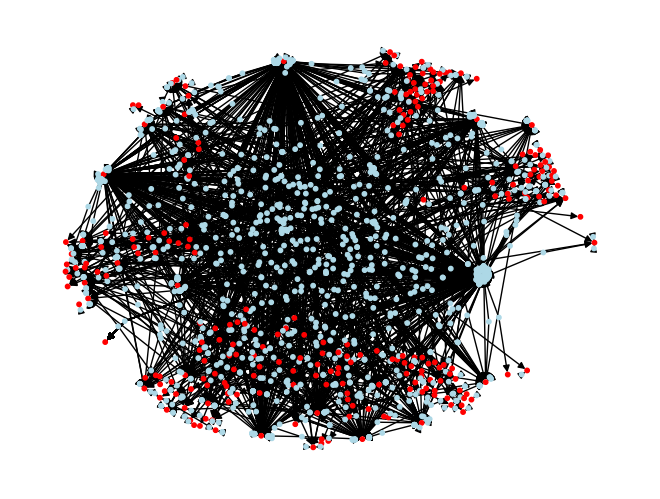

In [9]:
with open("data/af3_dnapos_kg.json") as f:
    data = json.load(f)

G = json_graph.node_link_graph(data, edges="edges")
print(G)

def node_color(x):
    return "lightblue" if type(x) == str else "red"

nx.draw(G, pos=nx.forceatlas2_layout(G), with_labels=False, node_size=10, font_size=4, node_color=[node_color(n) for n in G.nodes])

In [10]:
# use page rank to measure centrality
pagerank = nx.pagerank(G)
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

print("Nodes ranked by PageRank:")
for node, score in sorted_pagerank[:10]:  # top 10 nodes
    print(f"{node}: {score}")

Nodes ranked by PageRank:
3378: 0.08914336298020759
407: 0.06463532094933407
2558: 0.039951719546161224
4793: 0.0349818383177545
6445: 0.013610221944794937
1545: 0.011567120772629247
7612: 0.010795852276833759
4014: 0.009881919880671492
8707: 0.007177556194143527
5234: 0.0071685029486347265


In [11]:
# compare with degree centrality
degree_centrality = nx.degree_centrality(G)
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

print("Nodes ranked by Degree Centrality:")
for node, score in sorted_degree[:10]:  # top 10 nodes
    print(f"{node}: {score}")


Nodes ranked by Degree Centrality:
3378: 0.37181409295352325
407: 0.3353323338330835
2558: 0.1794102948525737
<cls>: 0.11644177911044477
4793: 0.11244377811094453
5746: 0.10944527736131934
G: 0.07896051974012994
C: 0.07196401799100449
6445: 0.062468765617191405
T: 0.056471764117941026


In [18]:
import pprint
pprint.pprint([e for e in G.edges(data=True) if len(e[2]["annotations"]) != 0][23][2])

{'annotations': {'CDS_1225841:77492170-77492220': {'end': 77492220,
                                                   'exon_id': 'XM_047417351.1.1',
                                                   'exon_number': '1',
                                                   'featuretype': 'CDS',
                                                   'gene_id': 'WDR41',
                                                   'gene_name': 'WDR41',
                                                   'start': 77492170,
                                                   'strand': '-',
                                                   'transcript_id': 'XM_047417351.1'},
                 'CDS_1225853:77492170-77492220': {'end': 77492220,
                                                   'exon_id': 'XM_005248552.4.1',
                                                   'exon_number': '1',
                                                   'featuretype': 'CDS',
                                             

In [12]:
# export to cytoscape for visualization
# Didn't work for the large graph, so just keeping for documentation
for node in G.nodes():
    G.nodes[node]['id'] = node

cyto_data = nx.readwrite.json_graph.cytoscape_data(G)
with open("data/cisplatin_pos_kg_cyto.json", "w") as f:
    json.dump(cyto_data, f)